### سهیل حمزه بیگی

### شماره دانشجویی: ۴۰۳۴۴۳۰۴۷

In [1]:
from google.colab import files
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

In [2]:
!pip install hmmlearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 1.0 MB/s eta 0:00:00


In [3]:
from hmmlearn import hmm

### Reading Data

In [4]:
zip_name = "/content/dataml.zip"

if not os.path.exists(zip_name):
    raise FileNotFoundError(f"ZIP file not found: {zip_name}")

with zipfile.ZipFile(zip_name, "r") as z:
    z.extractall("dataml")

print("Extracted to /content/dataml")

Extracted to /content/dataml


In [5]:
all_csvs = [f for f in os.listdir("dataml/dataml") if f.lower().endswith(".csv")]
if not all_csvs:
    raise RuntimeError("No CSV files found inside dataml/")

dfs = []
for fn in sorted(all_csvs):
    p = os.path.join("dataml/dataml", fn)
    df = pd.read_csv(p)
    df["source_file"] = fn
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
print("Combined shape:", data.shape)

Combined shape: (61195, 30)


In [6]:
combined_df = data
combined_df.to_csv("combined_dataset.csv", index=False)

print(f"Combined dataset saved as combined_dataset.csv with shape {combined_df.shape}")

Combined dataset saved as combined_dataset.csv with shape (61195, 30)


### Calculationg features

In [7]:
if "Time" not in combined_df.columns or "Speed" not in combined_df.columns:
    raise ValueError("The dataset must contain 'Time' and 'Speed' columns.")

In [8]:
# Acceleration
combined_df["Acceleration"] = combined_df["Speed"].diff().fillna(0) / combined_df["Time"].diff().fillna(1)
combined_df.loc[combined_df["source_file"] != combined_df["source_file"].shift(1), "Acceleration"] = 0

# Stop_Flag
combined_df["Stop_Flag"] = (combined_df["Speed"] < 1).astype(int)

# Gear_Change
if "Gear" in combined_df.columns:
    combined_df["Gear_Change"] = (combined_df["Gear"] != combined_df["Gear"].shift(1)).astype(int)
    combined_df.loc[combined_df["source_file"] != combined_df["source_file"].shift(1), "Gear_Change"] = 0
else:
    combined_df["Gear_Change"] = np.nan

# Speed_Change_Rate
combined_df["Speed_Change_Rate"] = combined_df["Speed"].diff().abs().fillna(0) / combined_df["Time"].diff().fillna(1)
combined_df.loc[combined_df["source_file"] != combined_df["source_file"].shift(1), "Speed_Change_Rate"] = 0

# Slope_Angle
if "Slope" in combined_df.columns:
    combined_df["Slope_Angle"] = combined_df["Slope"]
else:
    combined_df["Slope_Angle"] = np.nan

# Instant_Fuel_Rate
if "Fuel_Rate" in combined_df.columns:
    combined_df["Instant_Fuel_Rate"] = combined_df["Fuel_Rate"]
else:
    combined_df["Instant_Fuel_Rate"] = np.nan

In [9]:
combined_df.to_csv("combined_dataset_with_features.csv", index=False)
print(f"Combined dataset with features saved as combined_dataset_with_features.csv")
print(f"Final shape: {combined_df.shape}")

Combined dataset with features saved as combined_dataset_with_features.csv
Final shape: (61195, 36)


In [10]:
print(combined_df.head())

       Time  Engine speed  Intake manifold absolute pressure  \
0  460632.0         865.0                               41.0   
1  461476.0         873.0                               41.0   
2  462327.0         861.0                               41.0   
3  463170.0         870.0                               42.0   
4  464022.0         871.0                               41.0   

   Target air-fuel ratio  Battery voltage  Throttle position  \
0                   14.5             13.2              4.363   
1                   14.5             13.2              4.424   
2                   14.5             13.2              4.338   
3                   14.5             13.3              4.373   
4                   14.5             13.2              4.430   

   Accelerator pedal position  Coolant temperature  Speed  \
0                         0.0                 66.0    0.0   
1                         0.0                 67.0    0.0   
2                         0.0                 6

### Driving Phase Detection (based on speed thresholds)

In [11]:
def detect_phase(speed, standard="WLTC"):
    if standard == "WLTC":
        if speed < 1:
            return "Idle"
        elif speed <= 60:
            return "Urban"
        else:
            return "Extra-Urban"
    elif standard == "NEDC":
        if speed < 1:
            return "Idle"
        elif speed <= 50:
            return "Urban"
        else:
            return "Extra-Urban"
    elif standard == "JC08":
        if speed < 1:
            return "Idle"
        elif speed <= 40:
            return "Urban"
        else:
            return "Extra-Urban"
    elif standard == "FTP75":
        if speed < 1:
            return "Idle"
        elif speed <= 56:
            return "Urban"
        else:
            return "Extra-Urban"
    else:
        return np.nan

In [12]:
for std in ["WLTC", "NEDC", "JC08", "FTP75"]:
    combined_df[f"Phase_{std}"] = combined_df["Speed"].apply(lambda v: detect_phase(v, std))


combined_df.to_csv("combined_dataset_with_features_and_phases.csv", index=False)

print(f"Combined dataset with features & phases saved as combined_dataset_with_features_and_phases.csv")
print(f"Final shape: {combined_df.shape}")

Combined dataset with features & phases saved as combined_dataset_with_features_and_phases.csv
Final shape: (61195, 40)


In [13]:
print(combined_df.head())

       Time  Engine speed  Intake manifold absolute pressure  \
0  460632.0         865.0                               41.0   
1  461476.0         873.0                               41.0   
2  462327.0         861.0                               41.0   
3  463170.0         870.0                               42.0   
4  464022.0         871.0                               41.0   

   Target air-fuel ratio  Battery voltage  Throttle position  \
0                   14.5             13.2              4.363   
1                   14.5             13.2              4.424   
2                   14.5             13.2              4.338   
3                   14.5             13.3              4.373   
4                   14.5             13.2              4.430   

   Accelerator pedal position  Coolant temperature  Speed  \
0                         0.0                 66.0    0.0   
1                         0.0                 67.0    0.0   
2                         0.0                 6

### HMM (detect sequence structure)

In [14]:
# Feature Selection
hmm_features = combined_df[["Speed", "Acceleration", "Speed_Change_Rate"]].fillna(0).values

# Normalization
scaler = StandardScaler()
hmm_features_scaled = scaler.fit_transform(hmm_features)

# Training
n_states = 3  # فرض می‌کنیم 3 فاز کلی وجود دارد
hmm_model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=200, random_state=42)
hmm_model.fit(hmm_features_scaled)

# Prediction
hidden_states = hmm_model.predict(hmm_features_scaled)
combined_df["HMM_Phase"] = hidden_states

# Map to Average Speed
state_speed_means = {state: combined_df.loc[combined_df["HMM_Phase"] == state, "Speed"].mean() for state in range(n_states)}
sorted_states = sorted(state_speed_means, key=state_speed_means.get)

phase_names = {}
phase_names[sorted_states[0]] = "Idle"
phase_names[sorted_states[1]] = "Urban"
phase_names[sorted_states[2]] = "Extra-Urban"

combined_df["HMM_Phase_Name"] = combined_df["HMM_Phase"].map(phase_names)

In [15]:
combined_df.to_csv("combined_dataset_with_features_phases_hmm.csv", index=False)

print(f"Final dataset saved as combined_dataset_with_features_phases_hmm.csv")
print(f"Final shape: {combined_df.shape}")
print("Transition Matrix:")
print(hmm_model.transmat_)

✅ Final dataset saved as combined_dataset_with_features_phases_hmm.csv
📊 Final shape: (61195, 42)
📈 Transition Matrix:
[[0.36077874 0.20257461 0.43664665]
 [0.18470079 0.71154614 0.10375307]
 [0.12279751 0.02189255 0.85530994]]


### Main phases & Sub-Pattern Behaviors (Sub-HMMs) with WLTC

In [16]:
def detect_phase_wltc(speed):
    v = float(speed)
    if v < 1:
        return "Idle"
    elif v <= 60:
        return "Urban"
    else:
        return "Extra-Urban"

data["Phase_High"] = data["Speed"].apply(detect_phase_wltc)

In [17]:
features = data[["Speed", "Acceleration", "Speed_Change_Rate"]].fillna(0).values


scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


idle_data = features_scaled[data["Phase_High"] == "Idle"]
urban_data = features_scaled[data["Phase_High"] == "Urban"]
extra_data = features_scaled[data["Phase_High"] == "Extra-Urban"]

def train_subhmm(X, n_states=3, random_state=42):
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=200,
        random_state=random_state
    )
    model.fit(X)
    return model

In [18]:
idle_hmm = train_subhmm(idle_data, n_states=2)
urban_hmm = train_subhmm(urban_data, n_states=3)
extra_hmm = train_subhmm(extra_data, n_states=3)


phase_map = {"Idle": 0, "Urban": 1, "Extra-Urban": 2}
phase_seq = data["Phase_High"].map(phase_map).values.reshape(-1, 1)
top_hmm = hmm.MultinomialHMM(n_components=3, n_iter=200, random_state=42)
top_hmm.fit(phase_seq)

print("Top-level HMM transition matrix (between main phases):")
print(top_hmm.transmat_)

print("\nIdle sub-HMM transition matrix:")
print(idle_hmm.transmat_)

print("\nUrban sub-HMM transition matrix:")
print(urban_hmm.transmat_)

print("\nExtra-Urban sub-HMM transition matrix:")
print(extra_hmm.transmat_)



predicted_top_states = top_hmm.predict(phase_seq)
inv_phase_map = {v: k for k, v in phase_map.items()}
data["HHMM_TopPhase"] = [inv_phase_map[s] for s in predicted_top_states]

print("HHMM (با hmmlearn) آموزش داده شد.")

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Top-level HMM transition matrix (between main phases):
[[9.01320140e-04 9.99058562e-01 4.01179591e-05]
 [9.54638745e-01 7.97928839e-03 3.73819670e-02]
 [4.02174984e-01 1.24429527e-01 4.73395489e-01]]

Idle sub-HMM transition matrix:
[[0.9627054  0.0372946 ]
 [0.95887438 0.04112562]]

Urban sub-HMM transition matrix:
[[0.81681847 0.02175209 0.16142943]
 [0.11967151 0.51669387 0.36363462]
 [0.04865201 0.11808135 0.83326664]]

Extra-Urban sub-HMM transition matrix:
[[0.36435201 0.17464765 0.46100034]
 [0.21170909 0.5713598  0.21693111]
 [0.15186326 0.02600318 0.82213356]]
HHMM (با hmmlearn) آموزش داده شد.


### Generating driving time profiles (WLTC)


In [19]:
phase_percentages = {"Idle": 0.13, "Urban": 0.52, "Extra-Urban": 0.35}
total_time = 1800
phase_lengths = {p: int(total_time * perc) for p, perc in phase_percentages.items()}

synthetic_speed = []
synthetic_time = []
current_time = 0

for phase in ["Idle", "Urban", "Extra-Urban"]:
    phase_data = data[data["Phase_High"] == phase]["Speed"].values
    if len(phase_data) == 0:
        continue
    idx = np.random.choice(len(phase_data), size=phase_lengths[phase], replace=True)
    phase_speeds = np.clip(phase_data[idx], 0, None)
    for spd in phase_speeds:
        synthetic_time.append(current_time)
        synthetic_speed.append(spd)
        current_time += 1

Synthetic driving cycle saved as synthetic_driving_cycle.csv


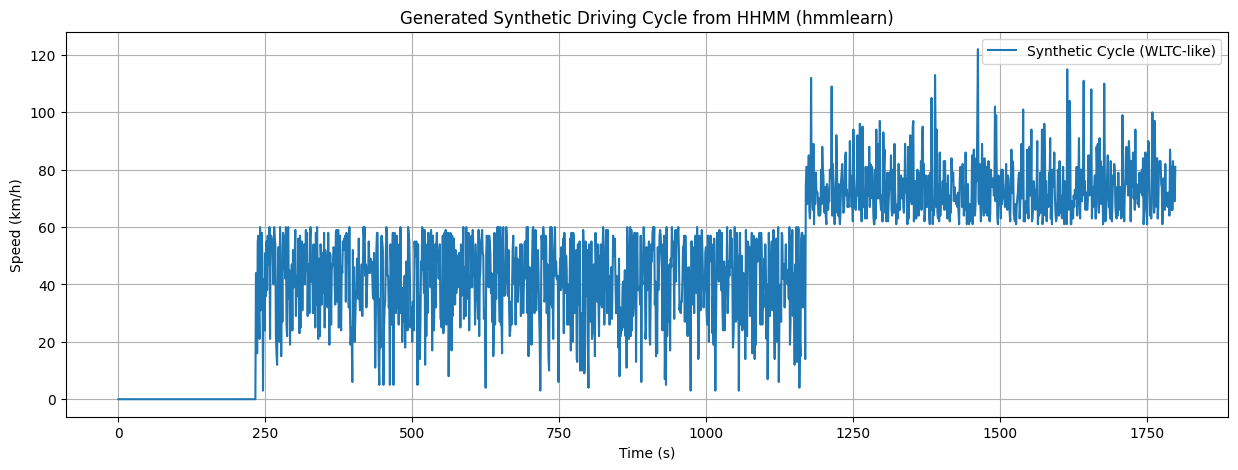

In [20]:
synthetic_df = pd.DataFrame({"Time": synthetic_time, "Speed": synthetic_speed})
synthetic_df.to_csv("/content/synthetic_driving_cycle.csv", index=False)
print("Synthetic driving cycle saved as synthetic_driving_cycle.csv")

import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(synthetic_df["Time"], synthetic_df["Speed"], label="Synthetic Cycle (WLTC-like)")
plt.xlabel("Time (s)")
plt.ylabel("Speed (km/h)")
plt.title("Generated Synthetic Driving Cycle from HHMM (hmmlearn)")
plt.grid(True)
plt.legend()
plt.show()

### Smoothing the profile، creating the final speed cycle، drawing the speed profile and saving it in a csv file

In [21]:
window_length = 15
polyorder = 3
smoothed_speed = savgol_filter(synthetic_df["Speed"], window_length, polyorder)


smoothed_speed = np.clip(smoothed_speed, 0, None)


synthetic_df["Speed_Smoothed"] = smoothed_speed

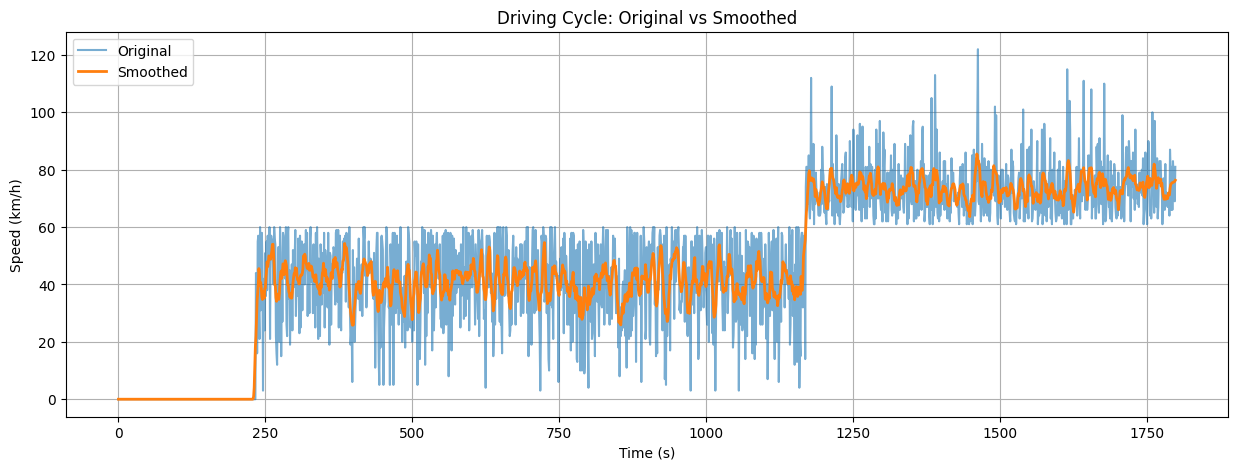

Final smoothed driving cycle saved to: /content/final_driving_cycle.csv


In [22]:
plt.figure(figsize=(15,5))
plt.plot(synthetic_df["Time"], synthetic_df["Speed"], label="Original", alpha=0.6)
plt.plot(synthetic_df["Time"], synthetic_df["Speed_Smoothed"], label="Smoothed", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Speed (km/h)")
plt.title("Driving Cycle: Original vs Smoothed")
plt.legend()
plt.grid(True)
plt.show()


output_path = "/content/final_driving_cycle.csv"
synthetic_df.to_csv(output_path, index=False)
print(f"Final smoothed driving cycle saved to: {output_path}")

### Training the HMM model to estimate vehicle gear

In [23]:
df = pd.read_csv("final_driving_cycle.csv")


if "Speed_Smoothed" in df.columns:
    speed = df["Speed_Smoothed"].values
else:
    speed = df["Speed"].values

time = df["Time"].values



acc = np.diff(speed, prepend=speed[0])
jerk = np.diff(acc, prepend=acc[0])

features = np.column_stack([speed, acc, jerk])
scaler = StandardScaler()
X = scaler.fit_transform(features)

In [24]:
try:
    df
except NameError:
    df = pd.read_csv("driving_cycle_with_all_stats.csv")


df = df.sort_values("Time").reset_index(drop=True)


dt = df["Time"].diff()
med_dt = np.nanmedian(dt.values) if np.isfinite(np.nanmedian(dt.values)) else 1.0
if not np.isfinite(med_dt) or med_dt <= 0:
    med_dt = 1.0
dt.iloc[0] = med_dt
dt = dt.replace(0, med_dt)

# features
acc = df["Speed"].diff() / dt
acc.iloc[0] = 0.0
jerk = acc.diff() / dt
jerk.iloc[0] = 0.0

df["Acceleration"] = acc
df["Jerk"] = jerk


feat_cols = ["Speed", "Acceleration", "Jerk"]
F = (
    df[feat_cols]
    .replace([np.inf, -np.inf], np.nan)
    .interpolate(limit_direction="both")
    .fillna(0.0)
    .to_numpy()
)

mask = np.isfinite(F).all(axis=1)
X = F[mask]

scaler = StandardScaler()
Xn = scaler.fit_transform(X)

n_states = 6
model = hmm.GaussianHMM(
    n_components=n_states,
    covariance_type="full",
    n_iter=300,
    random_state=42
)
model.fit(Xn)


states = model.predict(Xn)
speed_masked = df.loc[mask, "Speed"].to_numpy()
state_means = {s: float(speed_masked[states == s].mean()) for s in range(n_states)}
order = sorted(state_means, key=state_means.get)
state_to_gear = {st: g for g, st in enumerate(order)}
gears_masked = np.array([state_to_gear[s] for s in states], dtype=int)


gear_full = pd.Series(np.nan, index=df.index)
gear_full[mask] = gears_masked
gear_full = gear_full.ffill().bfill().astype(int)

df["Estimated_Gear"] = gear_full


out_path = "driving_cycle_with_gears_and_phase.csv"
df.to_csv(out_path, index=False)
print(f"Saved: {out_path}")
print("Columns:", df.columns.tolist())

✅ Saved: driving_cycle_with_gears_and_phase.csv
Columns: ['Time', 'Speed', 'Speed_Smoothed', 'Acceleration', 'Jerk', 'Estimated_Gear']


/tmp/ipython-input-3237511412.py:58: RuntimeWarning: Mean of empty slice.
  state_means = {s: float(speed_masked[states == s].mean()) for s in range(n_states)}
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


File saved as driving_cycle_with_gears.csv


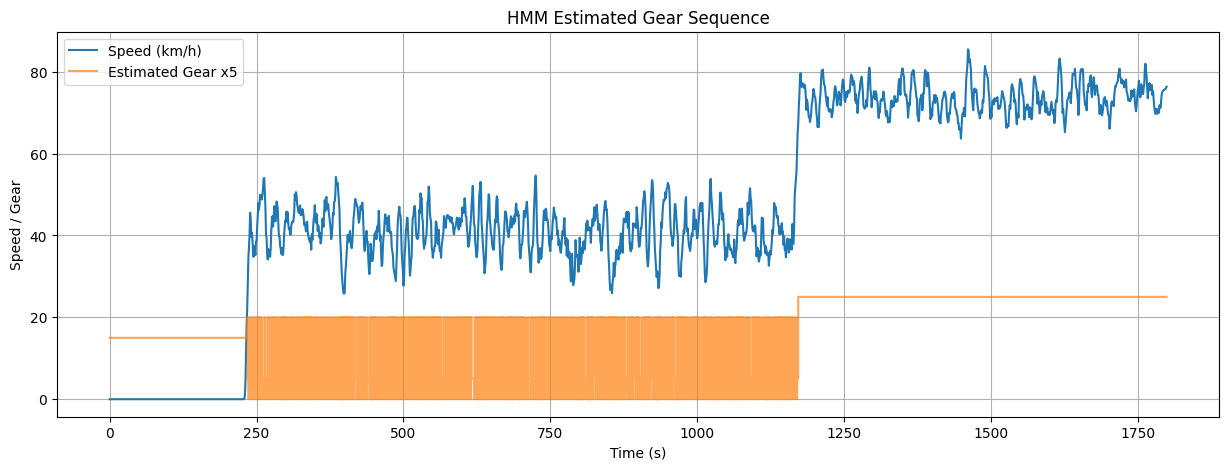

Transition matrix:
[[9.80404477e-002 2.24508226e-005 3.20919712e-061 9.01919865e-001
  1.72369879e-005 6.41249792e-055]
 [6.63340293e-001 2.07205822e-001 6.75716917e-069 5.57608793e-011
  1.29453885e-001 4.77347846e-073]
 [5.19427875e-025 5.18139276e-017 1.50573831e-015 6.55840355e-009
  6.96823722e-043 9.99999993e-001]
 [4.46971299e-001 5.53028561e-001 8.48531996e-044 1.31139335e-007
  9.54617826e-009 9.05633005e-042]
 [4.51167309e-002 1.06222865e-004 1.65941936e-105 7.03968575e-007
  9.54776342e-001 1.06766991e-106]
 [1.31752427e-025 3.68270754e-011 4.69172932e-008 4.27356216e-003
  1.84167673e-042 9.95726391e-001]]


In [25]:
df.to_csv("driving_cycle_with_gears.csv", index=False)
print("File saved as driving_cycle_with_gears.csv")

plt.figure(figsize=(15,5))
plt.plot(time, speed, label="Speed (km/h)")
plt.step(time, gear_full*5, where='post', label="Estimated Gear x5", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Speed / Gear")
plt.title("HMM Estimated Gear Sequence")
plt.legend()
plt.grid(True)
plt.show()


print("Transition matrix:")
print(model.transmat_)

### Reconstruction of the logical gear sequence in the previous stage output cycle, suitable for manual transmission vehicles

In [26]:
df = pd.read_csv("driving_cycle_with_gears_and_phase.csv")

speed = df["Speed"].values
time = df["Time"].values

# بازه‌های سرعت برای هر دنده
gear_ranges = {
    0: (0, 2),
    1: (0, 15),
    2: (10, 30),
    3: (20, 50),
    4: (40, 80),
    5: (70, 130)
}

In [27]:
# بازسازی توالی منطقی
logical_gears = []
current_gear = 0
hold_counter = 0
hold_threshold = 3

for i, v in enumerate(speed):
    candidate = current_gear
    for g, (vmin, vmax) in gear_ranges.items():
        if vmin <= v <= vmax:
            candidate = g
            break


    if candidate != current_gear:
        hold_counter += 1
        if hold_counter >= hold_threshold and abs(candidate-current_gear) == 1:
            current_gear = candidate
            hold_counter = 0
    else:
        hold_counter = 0

    logical_gears.append(current_gear)

df["Logical_Gear"] = logical_gears

In [28]:
df.to_csv("driving_cycle_with_logical_gears.csv", index=False)
print("Saved driving_cycle_with_logical_gears.csv")

print(df[["Time", "Speed", "Estimated_Gear", "Logical_Gear"]].head(20))

Saved driving_cycle_with_logical_gears.csv
    Time  Speed  Estimated_Gear  Logical_Gear
0      0    0.0               3             0
1      1    0.0               3             0
2      2    0.0               3             0
3      3    0.0               3             0
4      4    0.0               3             0
5      5    0.0               3             0
6      6    0.0               3             0
7      7    0.0               3             0
8      8    0.0               3             0
9      9    0.0               3             0
10    10    0.0               3             0
11    11    0.0               3             0
12    12    0.0               3             0
13    13    0.0               3             0
14    14    0.0               3             0
15    15    0.0               3             0
16    16    0.0               3             0
17    17    0.0               3             0
18    18    0.0               3             0
19    19    0.0               3      

### Extracting basic statistics for the Tehran cycle

In [29]:
df = pd.read_csv("driving_cycle_with_logical_gears.csv")

#
# Using WLTC
df[f"Phase"] = combined_df["Speed"].apply(lambda v: detect_phase(v, "WLTC"))
#

dt = np.median(np.diff(df["Time"].values))

# speed_mean
mean_speed_overall = df["Speed"].mean()
mean_speed_phase = df.groupby("Phase")["Speed"].mean()


phase_time_ratio = df["Phase"].value_counts(normalize=True) * 100  # درصد

# stops
idle_ratio = phase_time_ratio.get("Idle", 0)
idle_count = (df["Speed"] < 1e-2).sum()

# speed histogram
bins = np.arange(0, 141, 10)  # بازه‌های 0–10، 10–20، ...
hist_counts, bin_edges = np.histogram(df["Speed"], bins=bins)


distance_km = (df["Speed"] * dt / 3600).sum()

In [30]:
print(df)

      Time  Speed  Speed_Smoothed  Acceleration  Jerk  Estimated_Gear  \
0        0    0.0        0.000000           0.0   0.0               3   
1        1    0.0        0.000000           0.0   0.0               3   
2        2    0.0        0.000000           0.0   0.0               3   
3        3    0.0        0.000000           0.0   0.0               3   
4        4    0.0        0.000000           0.0   0.0               3   
...    ...    ...             ...           ...   ...             ...   
1795  1795   83.0       75.565201          17.0  32.0               5   
1796  1796   78.0       75.640832          -5.0 -22.0               5   
1797  1797   74.0       75.759071          -4.0   1.0               5   
1798  1798   69.0       75.970448          -5.0  -1.0               5   
1799  1799   81.0       76.325490          12.0  17.0               5   

      Logical_Gear        Phase  
0                0         Idle  
1                0         Idle  
2                0   

In [31]:
print("آمار پایه‌ای سیکل تهران")
print(f"میانگین سرعت کل: {mean_speed_overall:.2f} km/h")
print("میانگین سرعت در هر فاز:")
print(mean_speed_phase)
print("\nنسبت زمانی هر فاز به کل سیکل (%):")
print(phase_time_ratio)
print(f"\nتعداد توقف‌ها: {idle_count}")
print(f"درصد زمان توقف (Idle): {idle_ratio:.2f}%")
print(f"\nمسافت طی شده کل: {distance_km:.2f} km")

📊 آمار پایه‌ای سیکل تهران
میانگین سرعت کل: 47.11 km/h
میانگین سرعت در هر فاز:
Phase
Extra-Urban    47.312749
Idle           51.267176
Urban          45.995489
Name: Speed, dtype: float64

نسبت زمانی هر فاز به کل سیکل (%):
Phase
Extra-Urban    55.777778
Urban          36.944444
Idle            7.277778
Name: proportion, dtype: float64

تعداد توقف‌ها: 234
درصد زمان توقف (Idle): 7.28%

مسافت طی شده کل: 23.56 km


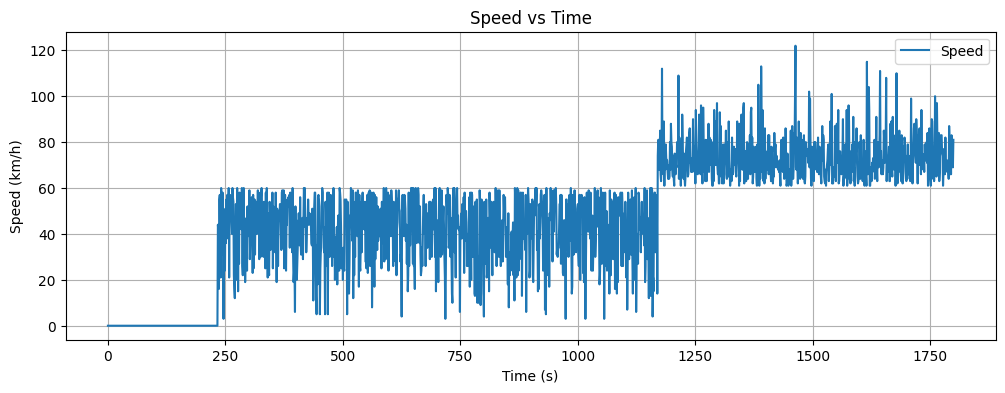

In [32]:
plt.figure(figsize=(12,4))
plt.plot(df["Time"], df["Speed"], label="Speed")
plt.xlabel("Time (s)")
plt.ylabel("Speed (km/h)")
plt.title("Speed vs Time")
plt.grid(True)
plt.legend()
plt.show()

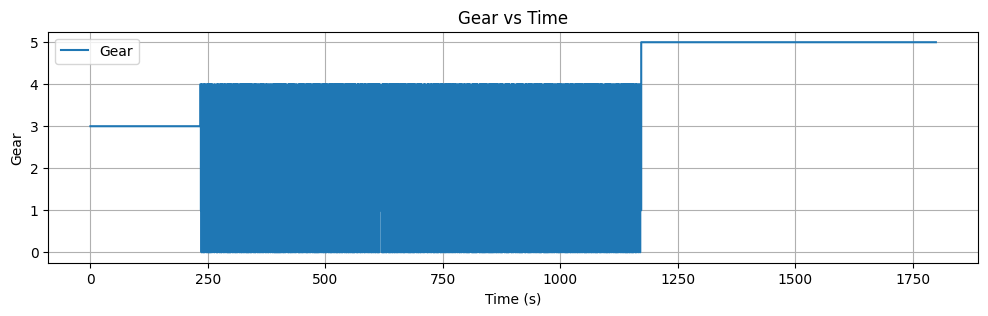

In [33]:
plt.figure(figsize=(12,3))
plt.step(df["Time"], df["Estimated_Gear"], where='post', label="Gear")
plt.xlabel("Time (s)")
plt.ylabel("Gear")
plt.title("Gear vs Time")
plt.grid(True)
plt.legend()
plt.show()

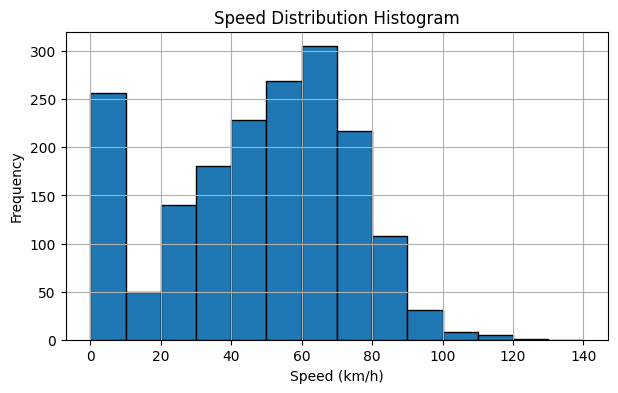

In [34]:
plt.figure(figsize=(7,4))
plt.hist(df["Speed"], bins=bins, edgecolor="black")
plt.xlabel("Speed (km/h)")
plt.ylabel("Frequency")
plt.title("Speed Distribution Histogram")
plt.grid(True)
plt.show()

### Saving to CSV File

In [35]:
df = pd.read_csv("driving_cycle_with_logical_gears.csv")

#
# Using WLTC
df[f"Phase"] = combined_df["Speed"].apply(lambda v: detect_phase(v, "WLTC"))
#

dt = np.median(np.diff(df["Time"].values))

# Acceleration (km/h per s)
df["Acceleration"] = df["Speed"].diff().fillna(0) / dt

df["Jerk"] = df["Acceleration"].diff().fillna(0) / dt


mean_speed_overall = df["Speed"].mean()
mean_speed_phase = df.groupby("Phase")["Speed"].mean().to_dict()
phase_time_ratio = df["Phase"].value_counts(normalize=True).to_dict()
idle_percent = phase_time_ratio.get("Idle", 0) * 100
distance_km = (df["Speed"] * dt / 3600).sum()

In [36]:
df["Mean_Speed_Overall"] = mean_speed_overall
df["Distance_Total_km"] = distance_km
df["Idle_Time_Percent"] = idle_percent

for ph, val in mean_speed_phase.items():
    df[f"Mean_Speed_{ph}"] = val

for ph, val in phase_time_ratio.items():
    df[f"Phase_Ratio_{ph}"] = val * 100

In [37]:
output_path = "driving_cycle_with_all_stats.csv"
df.to_csv(output_path, index=False)
print(f" فایل نهایی ذخیره شد: {output_path}")
print("ستون‌های فایل نهایی:")
print(df.columns.tolist())

✅ فایل نهایی ذخیره شد: driving_cycle_with_all_stats.csv
ستون‌های فایل نهایی:
['Time', 'Speed', 'Speed_Smoothed', 'Acceleration', 'Jerk', 'Estimated_Gear', 'Logical_Gear', 'Phase', 'Mean_Speed_Overall', 'Distance_Total_km', 'Idle_Time_Percent', 'Mean_Speed_Extra-Urban', 'Mean_Speed_Idle', 'Mean_Speed_Urban', 'Phase_Ratio_Extra-Urban', 'Phase_Ratio_Urban', 'Phase_Ratio_Idle']


### Calculating KLD and DTW

In [38]:
df = pd.read_csv("driving_cycle_with_all_stats.csv")

# KLD
bins = np.arange(0, 141, 10)


hist_counts, bin_edges = np.histogram(df["Speed"], bins=bins, density=False)
p = hist_counts / hist_counts.sum()

speed_ref = []
for phase, n in zip(df["Phase"].values, [len(df)//3, len(df)//3, len(df)-2*(len(df)//3)]):
    if phase == "Idle":
        speed_ref += [0]*n
    elif phase == "Urban":
        speed_ref += list(np.clip(np.random.normal(25, 10, n), 0, 60))
    else:  # Extra-Urban
        speed_ref += list(np.clip(np.random.normal(70, 15, n), 40, 110))
speed_ref = np.array(speed_ref)

In [39]:
# Speed distribution
ref_counts, _ = np.histogram(speed_ref, bins=bin_edges, density=False)
q = ref_counts / ref_counts.sum()

# Normalization
eps = 1e-9
p = np.clip(p, eps, 1.0); p /= p.sum()
q = np.clip(q, eps, 1.0); q /= q.sum()

# KLD
kld_pq = np.sum(p * np.log(p / q))   # KL(P||Q)
kld_qp = np.sum(q * np.log(q / p))   # KL(Q||P)

print("🔹 KLD (P||Q):", kld_pq)
print("🔹 KLD (Q||P):", kld_qp)

🔹 KLD (P||Q): 15.572390425979085
🔹 KLD (Q||P): 1.9464656149708681


In [40]:
# DTW
x = df["Speed"].values.astype(float)
y = speed_ref.astype(float)
N, M = len(x), len(y)

# DTW Matrix
D = np.full((N+1, M+1), np.inf)
D[0,0] = 0.0

for i in range(1, N+1):
    for j in range(1, M+1):
        cost = abs(x[i-1] - y[j-1])
        D[i,j] = cost + min(D[i-1,j], D[i,j-1], D[i-1,j-1])

dtw_distance = D[N,M]
print("🔹 DTW Distance:", dtw_distance)

🔹 DTW Distance: 84805.0


### Test Part (for TAs):

In [ ]:
# please uplead Your file as a Zip file with a name of ""dataml.
# then please Click Run all to run all parts.
# Thank you so much